In [1]:
# colab 사용할 경우
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # learning-rate scheduler
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

### GPU 설정 및 사전 데이터 업로드

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

과제에 사용될 데이터 중 대용량 데이터인 'soccer.zip'과 'animals10.zip'의 업로드 속도가 오래 걸림으로, 이 때 두 압축파일을 미리 업로드 해두는 걸 추천합니다.

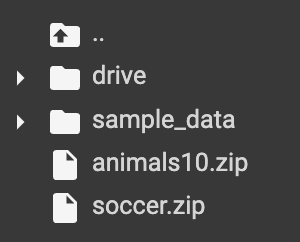

# Image Preprocessing
> 딥러닝에 필요한 이미지 조작 과정
* Haaland.zip & Mbappe.zip 파일을 현재 경로상(코랩기준 '/content')에 업로드 해주세요.
* 아래와 같이 되도록 데이터 업로드

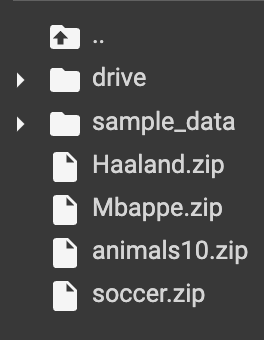

## Pillow-Library(PIL) 사용법 확인

In [5]:
from PIL import Image

In [6]:
# 본인의 구글 드라이브(현재 디렉터리)에 Haaland.zip 파일이 올라가 있어야 함!
# colab의 경우 content 폴더 바로 아래에 들어가면 됨

!ls # Haaland.zip 파일이 있는지 확인

drive  Haaland.zip  Mbappe.zip	sample_data  soccer.zip


In [7]:
# Haaland.zip 압축 풀기

!unzip -qq "Haaland.zip"
!ls # Haaland 폴더가 있는지 확인

animals10.zip  drive  Haaland  Haaland.zip  Mbappe.zip	sample_data  soccer.zip


In [8]:
# Haaland 폴더 안에 있는 데이터 확인

%cd /content/Haaland
!ls

/content/Haaland
Haaland1.jpeg  Haaland2.jpeg


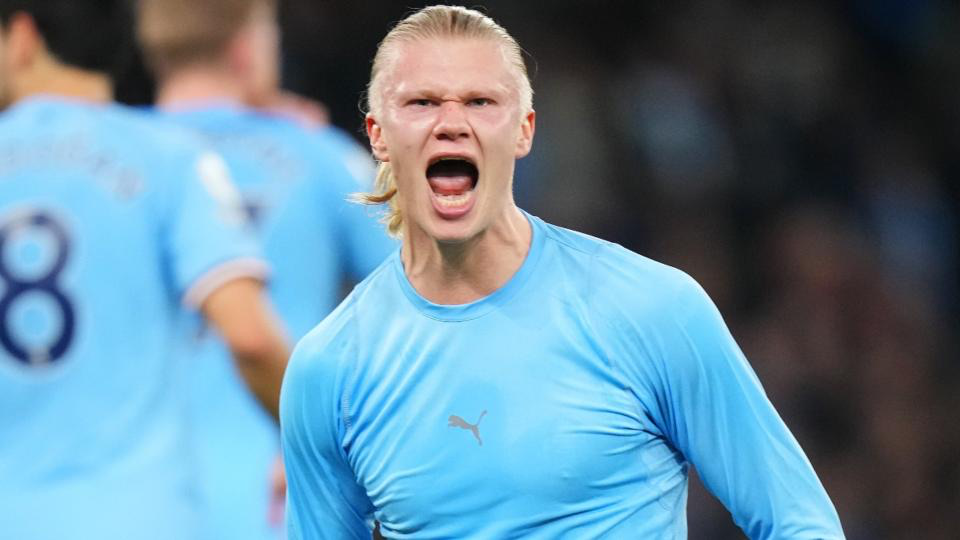

In [10]:
# pillow 라이브러리의 Image.open 함수로 해당 위치의 이미지를 읽어옴

path = 'Haaland1.jpeg'
Haaland_img1 = Image.open(path)
Haaland_img1

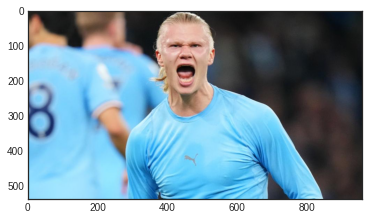

In [13]:
# 받아온 PIL 형태의 이미지를 numpy 형태로 변환

Haaland_img1_np = np.array(Haaland_img1)
plt.imshow(Haaland_img1_np)

In [14]:
# shape 확인
# height = 540, width = 960, channel = 3 (RGB) 임을 확인할수 있음

Haaland_img1_np.shape # 즉, 순서가 (H,W,C)이다.

(540, 960, 3)

In [15]:
# 가장 왼쪽 상단의 pixel (RGB) 값 확인
# data type = uint8 (only 0~255 사이 정수)

Haaland_img1_np[0,0,:] # 차례대로 R,G,B 3개의 값을 갖는다.

array([35, 33, 34], dtype=uint8)

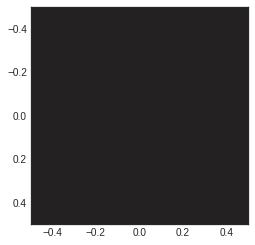

In [16]:
# 해당 픽셀이 나타내는 색상 확인

plt.imshow([[Haaland_img1_np[0,0,:]]])

In [17]:
# 가운데의 pixel (RGB) 값 확인
# data type = uint8 (only 0~255 사이 정수)

Haaland_img1_np[540//2,960//2,:]

array([170, 122,  99], dtype=uint8)

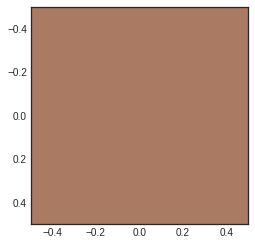

In [18]:
# 해당 픽셀이 나타내는 색상 확인

plt.imshow([[Haaland_img1_np[540//2,960//2,:]]])

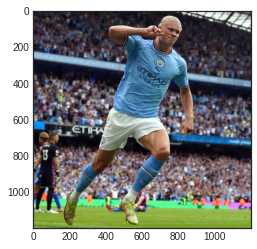

In [20]:
# Summary

# 1. jpg,jpeg,png(이미지파일) -> PIL 형태의 데이터
# pillow 라이브러리의 Image.open 함수

path = 'Haaland2.jpeg'
Haaland_img2 = Image.open(path)


# 2. PIL 형태의 데이터 -> numpy형태의 데이터
# np.array() 함수

Haaland_img2_np = np.array(Haaland_img2)
plt.imshow(Haaland_img2_np)

## ToTensor( ) 역할 확인

하는 역할

1. input데이터(PIL or numpy)를 tensor형태로 바꿔준다.

2. rgb값의 범위인 '0-255'를 '0-1'로 min-max scaling을 해준다.

이를 같이 해주는 것이 
`
torchvision.transforms.ToTensor()
`

In [21]:
import torchvision.transforms as transforms

In [22]:
# ToTensor만 사용해보자.

my_transform = transforms.Compose([
    transforms.ToTensor()
])

1. input데이터(PIL or numpy)를 tensor형태로 바꿔준다.

In [23]:
# PIL 이미지 -> Tensor형태의 데이터

Haaland_img_ts = my_transform(Haaland_img1)

# PIL 이미지 -> numpy형태의 데이터 -> Tensor형태의 데이터

Haaland_img_np = np.array(Haaland_img1)
Haaland_img_ts_np = my_transform(Haaland_img_np)

In [24]:
# PIL형태로 넣든지 혹은 numpy로 변경해서 넣든지,
# transforms.ToTensor()를 적용하면, 같은 output값이 나온다.

(Haaland_img_ts == Haaland_img_ts_np).numpy().all()

# 따라서 굳이 numpy로 바꿔줄 필요없이, PIL값을 input으로 넣으면 된다.

True

2. rgb값의 범위인 '0-255'를 '0-1'로 min-max scaling을 해준다.

* 참고) PIL 이미지는 (H, W, C) 형태이지만 이를 변환한 Tensor 이미지는 (C, H, W)임에 유의하자

In [25]:
# transforms.ToTensor() 적용 전의 input; PIL 이미지
# (H,W,C)

Haaland_img_np.shape

(540, 960, 3)

In [26]:
# transforms.ToTensor() 적용 후의 output
# (C,H,W)

Haaland_img_ts.shape

torch.Size([3, 540, 960])

In [27]:
# 가장 첫번째 pixel (RGB) 값 확인

# ToTensor() 적용 전
print(Haaland_img_ts[:,0,0], '\n')

# ToTensor() 적용 후
print(Haaland_img1_np[0,0,:], '\n')

# 직접 min-max를 진행한 결과
print(Haaland_img1_np[0,0,:]/np.max(Haaland_img1_np))

tensor([0.1373, 0.1294, 0.1333]) 

[35 33 34] 

[0.1372549  0.12941176 0.13333333]


## DataAugmentation 하는 법

* 굉장히 다양한 Augmentation 종류
* 너무 다양하게 쓸 필요는 없음 - 필요한 만큼만 적당히 쓰자
* 적용 후의 이미지를 보았을 때 이상하거나 성능이 좋지 않게 나온다면, 이 부분을 재수정한다.

In [28]:
# 보통 적용할 augmentation을 ToTensor, Normalize 전에 사용
my_transform = transforms.Compose([
    transforms.Resize(250),                 # 250으로 resize; tip) 이것만으로 W==H가 되지 않는다.
    transforms.RandomCrop(224),             # 랜덤으로 224만큼 crop; 따라서 여기 crop을 해주어야한다.
    transforms.RandomHorizontalFlip(p=0.5), # 0.5 확률로 horizontal flip
    transforms.RandomRotation(20),          # 랜덤으로 20도 만큼 rotate

    # 차례대로 수행함으로, tensor은 나중에 해준다.
    transforms.ToTensor(),
])

In [29]:
Haaland_augmented = my_transform(Haaland_img1) # PIL객체를 input으로 넣는다.

In [31]:
# 편의상 이미지 보여주기 위해 numpy 변환
# 편의상 이미지 보여주기 위해 차원 순서 바꾸자

Haaland_augmented_np = np.array(Haaland_augmented)
Haaland_augmented_tr = Haaland_augmented_np.transpose(1,2,0)


# size 바뀐 것 확인가능

print('기존 사이즈 :', Haaland_img1_np.shape)
print('변경된 사이즈 :', Haaland_augmented_tr.shape)

기존 사이즈 : (540, 960, 3)
변경된 사이즈 : (224, 224, 3)


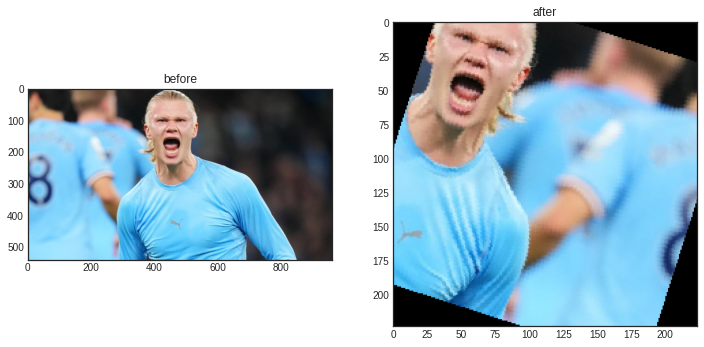

In [32]:
# 시각화

figure = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(Haaland_img1_np) # 전처리 전
plt.title('before')

plt.subplot(1,2,2)
plt.imshow(Haaland_augmented_tr) # 전처리 후
plt.title('after')

plt.show()

* 우리가 원하는 Augmentation 적용된 것 확인
* 충분히 위에서 normalized된 이미지와 비슷한 형태 - 고민할 것은 올바른 Augmentation 옵션의 활용 (모델이 이걸 Haaland로 분류하도록 할만큼 Haaland 같은 사진인가? 원래 특징 잃어버릴 정도로 너무 심하게 변환했을때? ex. 음식 뒤집으면)
* 너무 많이 적용시키면 underfitting 발생할수도
* 위 그림처럼 보통 모델에 들어가는 이미지의 차원 정사각형 형태로 맞춰줌
    * Ex. Resize(300) & RandomCrop(224)

## Normalize(mean,std) 역할 확인 및 mean & std 값 결정하는 2가지 방법 시도해보기

* 정규화의 이유 : 이미지 정규화를 진행하는 대표적인 이유 중 하나는 오차역전파(backpropagation)시, 그라디언트(Gradient) 계산을 수행하게 되는데, 데이터가 유사한 범위를 가지도록 하기 위함입니다.
* 사진이 여러개일 때는 mean과 std는 어떤 값으로 해야할까 ?
* 사진의 크기를 동일하게 맞춰야함으로, Data Augmentation이 사전적으로 진행되어야한다.

방법1. 모든 이미지에 대해서 channel인 R,G,B별로 mean과 std를 계산한다.

방법2. 대중적으로 많이 알려진 값을 사용한다.
* mean=[0.485, 0.456, 0.406]
* std=[0.229, 0.224, 0.225]

사용할 데이터 : Haaland.zip & Mbappe.zip

In [33]:
# 본인의 구글 드라이브(현재 디렉터리)에 Mbappe.zip 파일이 올라가 있어야 함!
# colab의 경우 content 폴더 바로 아래에 들어가면 됨

%cd ..
!ls # Mbappe.zip 파일이 있는지 확인

/content
animals10.zip  drive  Haaland  Haaland.zip  Mbappe.zip	sample_data  soccer.zip


In [34]:
# 압축 풀기

!unzip -qq "Mbappe.zip"
!ls # Mbappe 폴더가 있는지 확인

animals10.zip  Haaland	    Mbappe	sample_data
drive	       Haaland.zip  Mbappe.zip	soccer.zip


### 방법1. 모든 이미지에 대해서 channel인 R,G,B별로 mean과 std를 계산한다.

In [36]:
# 서로 다른 이미지 사이즈를 동일하게 맞춰준다.
# normalize는 진행하지 않는다.

my_transform = transforms.Compose([
    transforms.Resize(250),       # 250 resize
    transforms.RandomCrop(224),       # 랜덤으로 224만큼 crop -> (W,H)=(224,224)
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),

    transforms.ToTensor() # tensor로 변경 및 0~1 범위로 바꿔줌
])

In [52]:
import glob # glob.glob을 통해 특정한 형태의 경로를 가진 파일을 탐색하여, 그 경로(문자열)를 리스트에 저장해서 반환

Haaland = sorted(glob.glob('/content/Haaland/*.jpeg')) # * = 어떤 문자열
Mbappe = sorted(glob.glob('/content/Mbappe/*.jpeg'))

In [53]:
data = []
for path in Haaland+Mbappe:
    img = Image.open(path)
    img_ts = my_transform(img)
    data.append(img_ts)

In [54]:
def calculate_norm(data):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x in data])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x in data])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [55]:
mean_, std_ = calculate_norm(data)

print(mean_, std_)

(0.2805512, 0.2949607, 0.33172703) (0.24794498, 0.23602118, 0.2423068)


In [56]:
# normalize 부분 추가

my_transform = transforms.Compose([

    transforms.Resize(250),       # 250 resize
    transforms.RandomCrop(224),       # 랜덤으로 224만큼 crop -> (W,H)=(224,224)
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),

    transforms.ToTensor(),

    transforms.Normalize(mean_, std_) # 데이터로부터 직접 구한 값
])

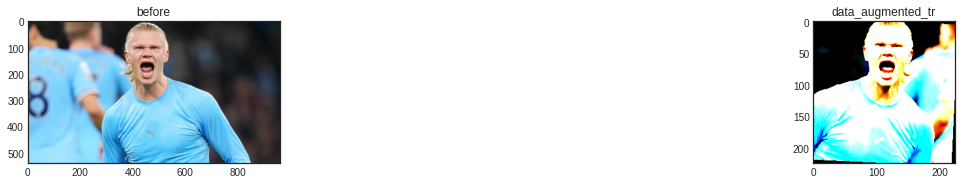

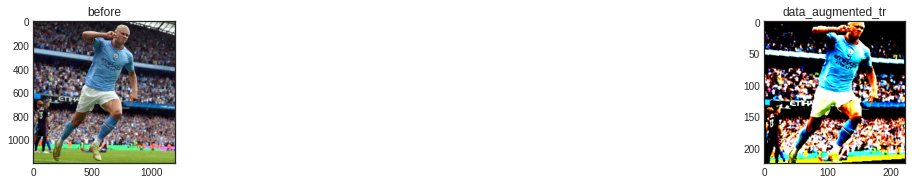

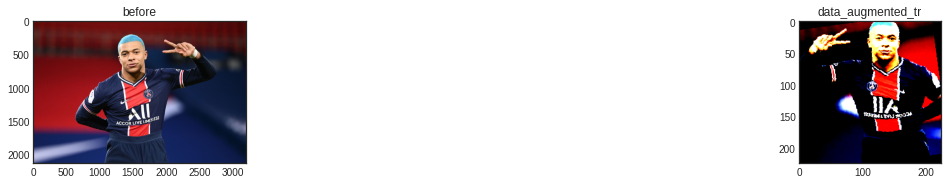

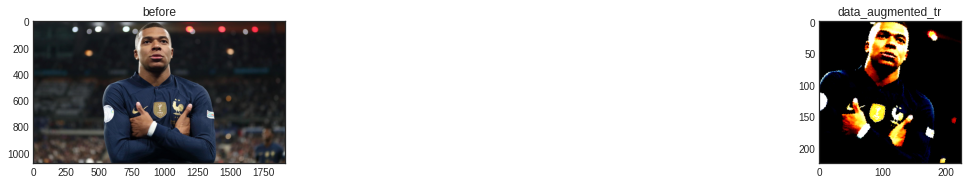

In [57]:
for i in range(len(Haaland+Mbappe)):

    path = (Haaland+Mbappe)[i]

    # 변경전 데이터
    data_origin = Image.open(path)
    data_origin_np = np.array(data_origin)

    # 전처리 후의 데이터
    data_augmented = my_transform(data_origin) # PIL객체를 input으로 넣는다.
    data_augmented_np = np.array(data_augmented)
    data_augmented_tr = data_augmented_np.transpose(1,2,0)

    # 시각화
    figure = plt.figure(figsize=(24,12))

    plt.subplot(len(Haaland+Mbappe),2,2*i+1)
    plt.imshow(data_origin_np) # 전처리 전
    plt.title('before')

    plt.subplot(len(Haaland+Mbappe),2,2*i+2)
    plt.imshow(data_augmented_tr) # 전처리 후
    plt.title('data_augmented_tr')

plt.show()

### 방법2. 대중적으로 많이 알려진 값을 사용한다.
* mean=[0.485, 0.456, 0.406]
* std=[0.229, 0.224, 0.225]

In [58]:
my_transform = transforms.Compose([
    transforms.Resize(300),                 
    transforms.RandomCrop(224),             
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),          

    transforms.ToTensor(),
    transforms.Normalize(mean_, std_) # 데이터로부터 직접 구한 값
])

In [59]:
my_transform_fr = transforms.Compose([
    transforms.Resize(300),                 
    transforms.RandomCrop(224),             
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),          

    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 대중적으로 많이 사용하는 값
])

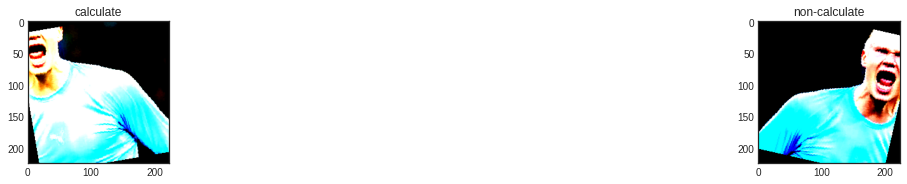

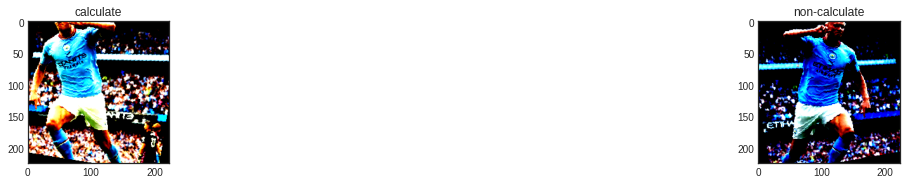

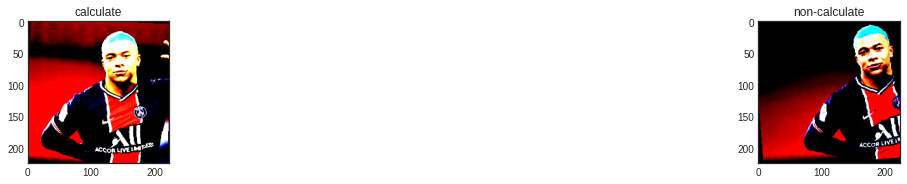

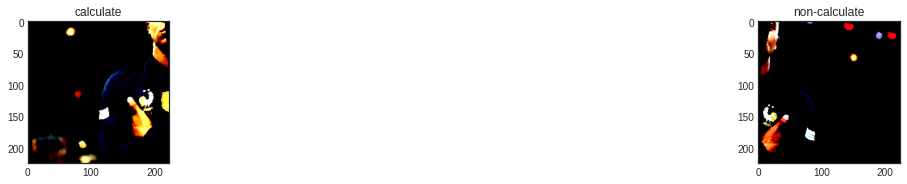

In [60]:
for i in range(len(Haaland+Mbappe)):

    path = (Haaland+Mbappe)[i]

    # 변경전 데이터
    data_origin = Image.open(path)
    data_origin_np = np.array(data_origin)

    # 직접구한 평균과 분산으로 전처리 후의 데이터
    data_augmented = my_transform(data_origin)
    data_augmented_np = np.array(data_augmented)
    data_augmented_tr = data_augmented_np.transpose(1,2,0)

    # 대중적인 평균과 분산으로 전처리 후의 데이터
    data_augmented_fr = my_transform_fr(data_origin)
    data_augmented_np_fr = np.array(data_augmented_fr)
    data_augmented_tr_fr = data_augmented_np_fr.transpose(1,2,0)
    
    # 시각화

    figure = plt.figure(figsize=(24,12))

    plt.subplot(len(Haaland+Mbappe),2,2*i+1)
    plt.imshow(data_augmented_tr) # 직접구함
    plt.title('calculate')

    plt.subplot(len(Haaland+Mbappe),2,2*i+2)
    plt.imshow(data_augmented_tr_fr) # 널리알려진값
    plt.title('non-calculate')

plt.show()

# 눈으로 봤을 때는 큰 차이가 없어보인다.

# Problem1) soccer.zip
> Step1. Pytorch에서 제공하지 않는 Dataset을 사용하기 위한 방법 (1)
*  ***ImageFolder( )*** 사용

> Step2. 전이학습 / 모델 학습(1)
* 기존 학습된 모델의 구조를 가져와 일부 구조만 변경한 뒤, 모든 weights를 재학습시킨다.
* 사전학습모델의 구조 변경과 더불어 모든 weights들은 학습시킨다.
    * 즉, resnet 전이학습 중 모델 모양만 가져와서 일부를 자신의 task에 맞게 변화시키고, 모델 전체 가중치 학습 진행

* soccer.zip 파일을 현재 경로상(코랩기준 '/content')에 업로드 해주세요.
    * 데이터 용량이 커서 시간이 많이 걸립니다.
    * 동그라미가 다 채워지면, 업로드가 완료된 것입니다.
    * 한 1시간 정도 걸리는 것 같네요.
    * 아래 이미지처럼 되게 해주세요.

## Step1. Pytorch에서 제공하지 않는 Dataset을 사용하기 위한 방법 (1)
* ImageFolder()

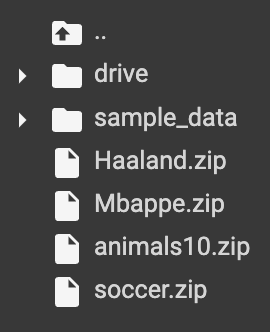

In [346]:
%cd /content

/content


In [347]:
# 현재 디렉토리 안에 'soccer.zip'이 존재하는지 확인

!ls

animals10      drive	Haaland.zip  Mbappe.zip  soccer.zip  val
animals10.zip  Haaland	Mbappe	     soccer	 train


### 데이터 구조 확인

In [348]:
# python에서 파일 관리해주는 라이브러리

import os
import glob
import shutil

In [349]:
!ls

animals10      drive	Haaland.zip  Mbappe.zip  soccer.zip  val
animals10.zip  Haaland	Mbappe	     soccer	 train


In [350]:
# 압축 풀기
# Tip) colab 기준, 내 컴퓨터에서 압축을 풀어 폴더를 업로드하는 것보다,
# 아래와 같은 명령어로 colab 내에서 압축을 풀어 진행하는 것이 데이터 접근 속도에 있어서 훨씬 빠름

!unzip -qq "soccer.zip"
!ls # soccer 폴더가 생겼는지 확인

replace soccer/Courtois/chrome_076AA3hINd.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
animals10      drive	Haaland.zip  Mbappe.zip  soccer.zip  val
animals10.zip  Haaland	Mbappe	     soccer	 train


In [351]:
# soccer 폴더 안으로 들어가보자.

%cd soccer
!ls # 8개의 폴더가 존재; 폴더이름이 y_label값이다.

/content/soccer
Courtois	  Dybala  LionelMessi	Neymar
CristianoRonaldo  Kross   MohamedSalah	Pogba


In [352]:
class_list = os.listdir("/content/soccer")
class_list

['Pogba',
 'MohamedSalah',
 'Neymar',
 'Courtois',
 'CristianoRonaldo',
 'LionelMessi',
 'Kross',
 'Dybala']

In [353]:
%cd ..

/content


In [354]:
path_dict = {}

for key in class_list:
    path_dict[key] = sorted(glob.glob('/content/soccer/{}/*.png'.format(key)))
path_dict

{'Pogba': ['/content/soccer/Pogba/Pogba1.png',
  '/content/soccer/Pogba/chrome_15nG2R4P5K.png',
  '/content/soccer/Pogba/chrome_1TVzTmNhOF.png',
  '/content/soccer/Pogba/chrome_1bx8KXH1fz.png',
  '/content/soccer/Pogba/chrome_1ibgcIv4gd.png',
  '/content/soccer/Pogba/chrome_1k2f14cz4a.png',
  '/content/soccer/Pogba/chrome_2G5C4mwQ3c.png',
  '/content/soccer/Pogba/chrome_2RHp0MEK9i.png',
  '/content/soccer/Pogba/chrome_2UOwzRkZ7z.png',
  '/content/soccer/Pogba/chrome_34XdObvamC.png',
  '/content/soccer/Pogba/chrome_3PC7zb86qq.png',
  '/content/soccer/Pogba/chrome_3Ya0p3PVPu.png',
  '/content/soccer/Pogba/chrome_3etzsVwG6W.png',
  '/content/soccer/Pogba/chrome_475uQxS6AK.png',
  '/content/soccer/Pogba/chrome_4ZdNh9PMub.png',
  '/content/soccer/Pogba/chrome_4abFgcBCf4.png',
  '/content/soccer/Pogba/chrome_4sMhxWFfJG.png',
  '/content/soccer/Pogba/chrome_56bNZTbSo5.png',
  '/content/soccer/Pogba/chrome_5Qt6f96pc9.png',
  '/content/soccer/Pogba/chrome_5j1G51d4FZ.png',
  '/content/soccer/Pog

In [355]:
for key in path_dict:
    print(key, len(path_dict[key]))

Pogba 302
MohamedSalah 317
Neymar 69
Courtois 316
CristianoRonaldo 203
LionelMessi 333
Kross 301
Dybala 305


편의를 위해 폴더 구조를

> * train/Courtois/xxx.png
> * train/CristianoRonaldo/xxx.jpg
> * ...
> * train/Pogba/xxx.jpg

> * val/Courtois/xxx.png
> * val/CristianoRonaldo/xxx.jpg
> * ...
> * val/Pogba/xxx.jpg

로 두어 이미지를 배치하는 것이 좋다.
따라서 현재 이미지를 train / val 폴더로 적절히 split해보자
* 나중에 ImageFolder를 사용해 Dataset을 만들려면, 이런 구조를 갖춰야하기 때문이다.

### 데이터 train/val split
* 20%의 데이터를 val로 활용하자

In [356]:
# val에 넣을 이미지 개수 계산

val_num_dict = {}

for key in path_dict:
    val_num_dict[key] = round(len(path_dict[key])*0.2)
    print(key, val_num_dict[key])

Pogba 60
MohamedSalah 63
Neymar 14
Courtois 63
CristianoRonaldo 41
LionelMessi 67
Kross 60
Dybala 61


In [357]:
import random

def split(img_list, val_count, train_path, val_path):
  # img_list : 이미지 경로 리스트
  # val_count : val에 할당할 이미지 개수
  # train_path : train 데이터 넣을 경로
  # val_path : val 데이터 넣을 경로
  

  # val 담을 이미지 리스트 저장
  val_files=[]
  for i in random.sample(img_list, val_count): # 랜덤으로 val_count만큼 이미지 img_list에서 고르기
    val_files.append(i)

  # 위에서 고르지 않은 이미지들을 train 담을 이미지 리스트로 저장
  train_files = [x for x in img_list if x not in val_files] # 리스트내포

  # 고른 이미지를 train_path, val_path폴더에 폭사
  for k in train_files:
    shutil.copy(k, train_path)
  
  for c in val_files:
    shutil.copy(c, val_path)

  print('train 폴더 이미지 개수 : {}\nval 폴더 이미지 개수 : {}'.format(len(glob.glob(train_path+'/*')),len(glob.glob(val_path+'/*'))))

In [360]:
!ls

animals10      drive	Haaland.zip  Mbappe.zip  soccer.zip  val
animals10.zip  Haaland	Mbappe	     soccer	 train


In [362]:
# 폴더 경로 선언 & 만들기

for key in path_dict:
    path = '/content/{}/{}'.format('train',key)
    os.makedirs(path, exist_ok=True)
    path = '/content/{}/{}'.format('val',key)
    os.makedirs(path, exist_ok=True)

In [363]:
!ls # train, val 폴더가 있는지 확인

animals10      drive	Haaland.zip  Mbappe.zip  soccer.zip  val
animals10.zip  Haaland	Mbappe	     soccer	 train


In [364]:
!pwd

/content


In [365]:
for key in path_dict:
    train_path = '/content/train/{}'.format(key)
    val_path = '/content/val/{}'.format(key)

    split(path_dict[key], val_num_dict[key], train_path, val_path)

train 폴더 이미지 개수 : 242
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 254
val 폴더 이미지 개수 : 63
train 폴더 이미지 개수 : 55
val 폴더 이미지 개수 : 14
train 폴더 이미지 개수 : 253
val 폴더 이미지 개수 : 63
train 폴더 이미지 개수 : 162
val 폴더 이미지 개수 : 41
train 폴더 이미지 개수 : 266
val 폴더 이미지 개수 : 67
train 폴더 이미지 개수 : 241
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 244
val 폴더 이미지 개수 : 61


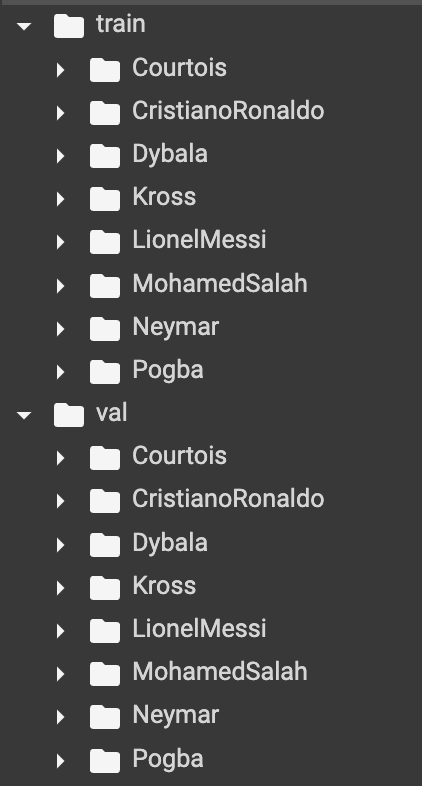

### 이미지 순서대로 넘버링
* 각 폴더 안에서 편의를 위해 0번부터 넘버링되도록 파일 이름을 바꾸자
* 추후에 나올 `ImageFolder`를 활용한다면 굳이 거쳐야 하는 과정은 아님

In [366]:
# random한 번호로 값이 들어가있다.

flat_val = sorted(glob.glob('/content/val/Courtois/*.png'))
flat_val[:5]

['/content/val/Courtois/chrome_076AA3hINd.png',
 '/content/val/Courtois/chrome_0NVe1Cb1BN.png',
 '/content/val/Courtois/chrome_2atr07XQsk.png',
 '/content/val/Courtois/chrome_9gG1smFpxW.png',
 '/content/val/Courtois/chrome_9ySwZih8lq.png']

In [367]:
i = 4
print(f'{i:0>5}') # 이 형식으로 바꿀예정

i = 200
print(f'{i:0>5}') # 이 형식으로 바꿀예정

00004
00200


In [368]:
def rename(img_dir):
  # img_dir : rename을 할 대상 폴더

  file_list = sorted(glob.glob(img_dir+'/*.png')) # 들어있는 파일이름 리스트
  
  for i in range(len(file_list)):
    os.rename(file_list[i], os.path.join(img_dir, f'{i:0>5}.png')) # 순서대로 0000i.png 이름 변경

In [337]:
for key in path_dict:
    path = '/content/train/{}'.format(key)
    rename(path)
    path = '/content/val/{}'.format(key)
    rename(path)

In [338]:
# 잘 rename 되었는지 확인

flat_train = sorted(glob.glob('/content/train/Courtois/*.png'))
flat_val = sorted(glob.glob('/content/val/Courtois/*.png'))

print(flat_train[:5])
print(flat_val[-5:])

['/content/train/Courtois/00000.png', '/content/train/Courtois/00001.png', '/content/train/Courtois/00002.png', '/content/train/Courtois/00003.png', '/content/train/Courtois/00004.png']
['/content/val/Courtois/00058.png', '/content/val/Courtois/00059.png', '/content/val/Courtois/00060.png', '/content/val/Courtois/00061.png', '/content/val/Courtois/00062.png']


### ImageFolder로 datasets 제작하기 및 datasets 확인하기

#### ImageFolder
* 위와 같이 폴더 배치를 했다면 `torchvision.datasets.ImageFolder`를 활용하여 바로 Dataset 선언할 수 있음

오늘 시도한 raw 데이터를 가지고 Dataset만드는 방법
* datasets.ImageFolder( )

In [369]:
# 서로 다른 이미지 사이즈를 동일하게 맞춰준다.

my_transform = transforms.Compose([
    transforms.Resize(250),                # 250으로 resize
    transforms.RandomCrop(224),             # 랜덤으로 224만큼 crop
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),
    
    transforms.ToTensor() # tensor로 변경
])

In [370]:
!ls # 해당 경로안에 val와 train 폴더가 있도록 이동해준다.

animals10      drive	Haaland.zip  Mbappe.zip  soccer.zip  val
animals10.zip  Haaland	Mbappe	     soccer	 train


In [371]:
# datasets.ImageFolder()로 datasets 만들기

train_data = torchvision.datasets.ImageFolder(
    root = '/content/train', # 바로 train 폴더 지정
    transform = my_transform # 정규화를 하지 않은 transform
)
val_data = torchvision.datasets.ImageFolder(
    root = '/content/val',
    transform = my_transform
)

ImageFolder( )로 만든 Dataset 특성 확인

In [372]:
train_data

Dataset ImageFolder
    Number of datapoints: 1717
    Root location: /content/train
    StandardTransform
Transform: Compose(
               Resize(size=250, interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [373]:
train_data[0] # 1번쨰 데이터

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]), 0)

In [374]:
# 1번쨰 데이터의 X값(이미지 정보)

train_data[0][0].shape # 모양만 확인

torch.Size([3, 224, 224])

In [375]:
# 1번쨰 데이터의 y값(label 클래쓰 정보)

train_data[0][1]

0

In [376]:
# 모든 데이터의 y값(label 클래쓰 정보)

y_list = []

for i in range(len(train_data)):
    y_list.append(train_data[i][1])

import pandas as pd
y_pd = pd.Series(np.array(y_list)).value_counts()
y_pd = y_pd.sort_index()
y_pd

0    253
1    162
2    244
3    241
4    266
5    254
6     55
7    242
dtype: int64

### 데이터에 맞는 transforms 찾기

#### 1. 사이즈 조절

기존의 my_transform을 적용한 결과에 대한 시각화
* 각 클래쓰 별로 일부 데이터를 가져와서 확인해보자.

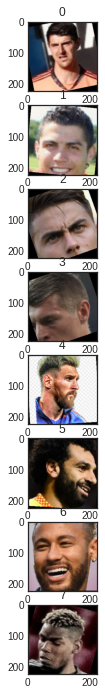

In [377]:
figure = plt.figure(figsize=(24,12))

for i in range(len(y_pd.index)): # Courtois/CristianoRonaldo/.../Pogba

    data_np = np.array(train_data[y_pd[:i].sum()][0])
    data_tr = data_np.transpose(1,2,0)

    plt.subplot(len(y_pd.index),1,i+1)
    plt.imshow(data_tr)
    plt.title('{}'.format(train_data[y_pd[:i].sum()][1]))

plt.show()

#### 2. 정규화를 위한 평균,표준편차 구하기
* 사진의 이미지 크기(HxW)를 동일하게 변경시켜준 뒤에, 평균과 표준편차를 구한다.

In [378]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [379]:
# train 데이터만을 기준으로 평균과 표준편차를 구해서 넣는다.

mean_, std_ = calculate_norm(train_data)

print(mean_, std_)

(0.4458371, 0.35646722, 0.3108993) (0.2676506, 0.22396941, 0.20680314)


In [380]:
my_transform = transforms.Compose([
    transforms.Resize(250),                 # 250으로 resize
    transforms.RandomCrop(224),             # 랜덤으로 224만큼 crop
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),
    
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_)

])

In [381]:
# datasets.ImageFolder()로 datasets 만들기

train_data = torchvision.datasets.ImageFolder(
    root = '/content/train', # 바로 train 폴더 지정
    transform = my_transform # 정규화를 하지 않은 transform
)
val_data = torchvision.datasets.ImageFolder(
    root = '/content/val',
    transform = my_transform
)

In [382]:
# 정규화 적용 후

mean_, std_ = calculate_norm(train_data)
print('train :', mean_, std_)

mean_, std_ = calculate_norm(val_data)
print('val :', mean_, std_)

train : (-0.00083990436, 9.4618714e-05, 0.002375901) (1.0014518, 1.0022855, 1.0040255)
val : (0.01068857, 0.028638061, 0.03698072) (1.0092449, 1.008163, 1.0059152)


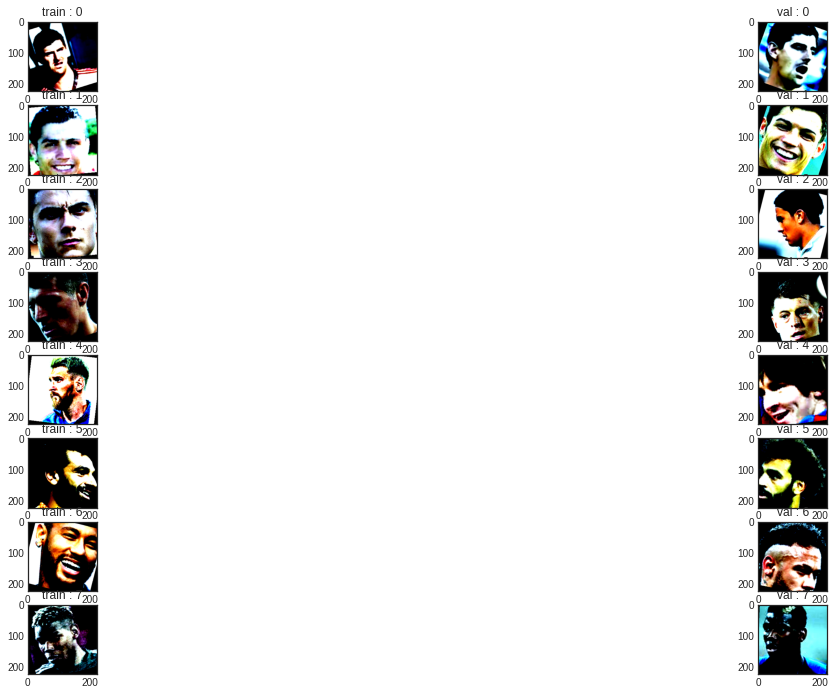

In [383]:
# train/val 데이터 시각화

figure = plt.figure(figsize=(24,12))

data_list = [train_data, val_data]
name_list = ['train', 'val']

for i in range(len(data_list)):

    # 각 train/val 별 y-value값으로 사이즈 확인
    y_list = []

    for k in range(len(data_list[i])):
        y_list.append(data_list[i][k][1])

    y_pd = pd.Series(np.array(y_list)).value_counts().sort_index()

    for j in range(len(y_pd.index)): # flat/full/no-animals10

        data_np = np.array(data_list[i][y_pd[:j].sum()][0])
        data_tr = data_np.transpose(1,2,0)

        plt.subplot(len(y_pd.index),2,i+2*j+1)
        plt.imshow(data_tr)
        plt.title('{} : {}'.format(name_list[i], data_list[i][y_pd[:j].sum()][1]))

plt.show()

# 시각적으로 구분이 가능해보인다.

## Step2. 전이학습 / 모델 학습(1)
* 기존 학습된 모델의 구조를 가져와 일부 구조만 변경한 뒤, 모든 weights를 재학습시킨다.

### 전처리 설정

In [386]:
# 위에서 결정된 transform을 토대로, train/val에 대한 transform-dictionary 정의하기

data_transforms = {'train': transforms.Compose( [
                        transforms.Resize(250), # 250으로 resize
                        transforms.RandomCrop(224), # 랜덤으로 224만큼 crop
                        transforms.RandomHorizontalFlip(p=0.5), 
                        transforms.RandomRotation(20),
                        
                        transforms.ToTensor(),
                        transforms.Normalize(mean_, std_)   # rgb임으로 3개씩
                        ] ), 
                   
                   'val': transforms.Compose( [
                        transforms.Resize(250),
                        transforms.CenterCrop(224), # 최종적으로 train과 같이 224로 바꿔준다.
                        transforms.ToTensor(),
                        transforms.Normalize(mean_, std_)   # 위와 동일
                        ] ) 
                   }

In [387]:
data_dir = '/content'

# ImageFolder( ) 로 datasets 정의
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val']}

# DataLoader( ) 로 batch-size 만큼 데이터를 쪼갠 그룹 만들기
dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [388]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f36dfb2a7c0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f37aae9d2e0>}

In [389]:
for inputs, labels in dataloaders['train']:
    print(inputs.shape, '\n')
    print(labels.shape)

    break;

torch.Size([4, 3, 224, 224]) 

torch.Size([4])


In [391]:
dataset_sizes

{'train': 1717, 'val': 429}

In [392]:
class_names

['Courtois',
 'CristianoRonaldo',
 'Dybala',
 'Kross',
 'LionelMessi',
 'MohamedSalah',
 'Neymar',
 'Pogba']

In [393]:
len(class_names)

8

### 사전훈련된 모델 로드

In [394]:
model_ft = models.resnet18(pretrained=True) # torchvision 라이브러리로부터 이미 학습된 모델인 'resnet18'을 가져온다.
model_ft

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000
  - 가장 마지막의 layer이자 유일한 fc-layer의 output node 값이 1,000개로 1,000개의 class로 분류가 되는 모델이다.
  - 따라서 우리의 분류문제는 8개의 class인 Courtois, CristianoRonaldo,...,Pogba 임으로, 해당 변수를 nn.Linear(512, 8) 로 변경해주자.

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [396]:
# model class의 fc 변수 중 out_features를 변경

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 8) # ?? = Courtois, CristianoRonaldo,...,Pogba

# gpu위에 올린다.
model_ft = model_ft.to(device)

### 손실함수와 옵티마이저

In [399]:
criterion = nn.CrossEntropyLoss() # 분류 -> 다중 cross-entropy

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [400]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler

- 학습 함수 정의

### model의 train & validation 동시 구현

In [409]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # 시작시점 기록

    # 모델의 weight(가중치)를 깊은 복사하여, 이 변수가 변해도 해당 모델의 weight가 변하지 않도록 한다.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs): # epochs만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train','val']: # train -> validation 순차 진행
            if phase == 'train':
                model.train() # train일 때는, layer의 batch-normal과 drop-out 등 을 활성화시킨다.
            else:
                model.eval() # validation(=evaluation) 때는, layer의 batch-normal과 drop-out 등 을 비활성화시킨다.
                # 즉, 이전에 train에서 정해진 값들로 정해지고, update는 없다.

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # batch마다
                inputs = inputs.to(device) # gpu위에 올린다; [4, 3, 224, 224]
                labels = labels.to(device) # gpu위에 올린다; [4]

                optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

                with torch.set_grad_enabled(phase == 'train'): # train일 때, True로 새로 정의된 변수들의 연산들이 추적되어 gradient가 계산된다.
                    outputs = model(inputs) # 실수값
                    _, preds = torch.max(outputs, 1) # 가장 큰 값을 선택; 분류
                    loss = criterion(outputs, labels) # loss-function

                    if phase == 'train':
                        loss.backward() # back-propagation; gradient 계산
                        optimizer.step() # parameters(weights) update
                
                running_loss += loss.item() * inputs.size(0) # inputs.size(0) = batch-size; 4
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # validation의 목적; train 시킨 후에, 정해진 각 epochs마다 모델 성능을 비교하여, 가능 좋은 값을 찾아낸다.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts) # 가장 좋은 성능을 보인 가중치로 바꿔주기
    return model


In [410]:
# 모델 train & validation

model_ft = train_model(dataloaders, model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2994	Accuracy: 0.9080
val Loss: 0.1168	Accuracy: 0.9697

Epoch 1/9
----------
train Loss: 0.2855	Accuracy: 0.9138
val Loss: 0.0998	Accuracy: 0.9674

Epoch 2/9
----------
train Loss: 0.2634	Accuracy: 0.9295
val Loss: 0.0983	Accuracy: 0.9674

Epoch 3/9
----------
train Loss: 0.1993	Accuracy: 0.9319
val Loss: 0.0854	Accuracy: 0.9790

Epoch 4/9
----------
train Loss: 0.1422	Accuracy: 0.9540
val Loss: 0.0587	Accuracy: 0.9860

Epoch 5/9
----------
train Loss: 0.1051	Accuracy: 0.9680
val Loss: 0.0499	Accuracy: 0.9860

Epoch 6/9
----------
train Loss: 0.0999	Accuracy: 0.9726
val Loss: 0.0538	Accuracy: 0.9883

Epoch 7/9
----------
train Loss: 0.0896	Accuracy: 0.9750
val Loss: 0.0526	Accuracy: 0.9907

Epoch 8/9
----------
train Loss: 0.0745	Accuracy: 0.9819
val Loss: 0.0475	Accuracy: 0.9907

Epoch 9/9
----------
train Loss: 0.0800	Accuracy: 0.9790
val Loss: 0.0468	Accuracy: 0.9883

Training time: 2m 58s
Best Validation Accuracy: 0.9907


### 결과 시각화

- 시각화 함수 정의

In [411]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [412]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

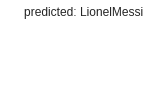

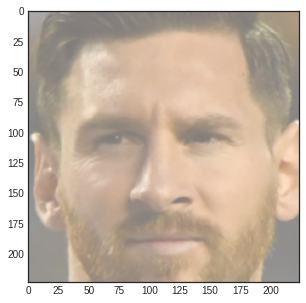

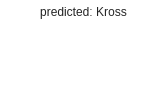

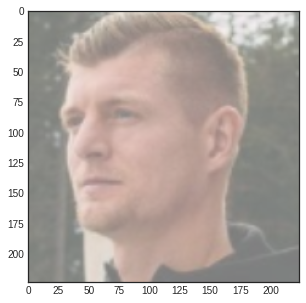

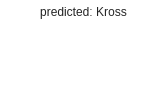

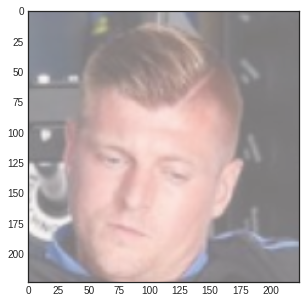

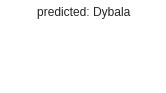

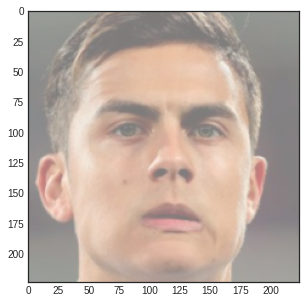

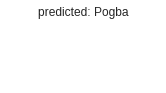

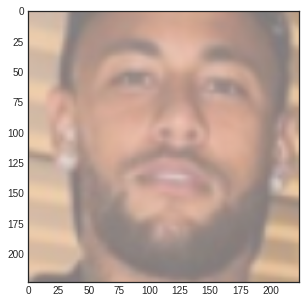

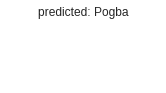

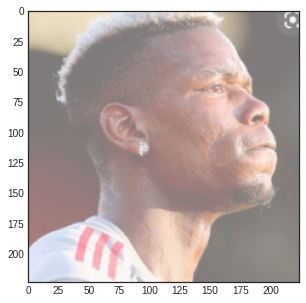

In [413]:
visualize_model(model_ft)

# Problem2) animals10.zip
> Step1. Pytorch에서 제공하지 않는 Dataset을 사용하기 위한 방법 (1)
* ***Custom Dataset Class 만들기***
    * 직접 Datset 클래스 만들기 - 추후 더 복잡한 task에 유용
    * 우리가 원하는대로 함수 내용 정하면됨
    * 예를 들어, RAM이 부족한 환경에서 해당 데이터의 일부만 가져다가 저장할 수 있다.


> Step2. 전이학습 / 모델 학습(2)
* 고정된 특징 추출기로써의 합성곱 신경망
* 구조 변경은 하였지만, 변경한 구조를 제외한 나머지 weights들은 고정시킨다.
* 마지막 계층을 제외한 신경망의 모든 부분을 고정
*  `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.

* animals10.zip 파일을 현재 경로상(코랩기준 '/content')에 업로드 해주세요.
    * 데이터 용량이 커서 시간이 많이 걸립니다.
    * 동그라미가 다 채워지면, 업로드가 완료된 것입니다.
    * 한 1~2시간 정도 걸리는 것 같네요.
    * 아래 이미지처럼 되게 해주세요.

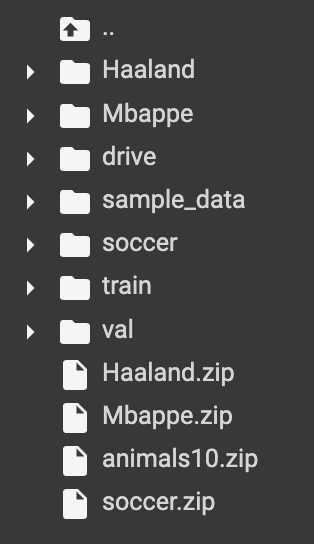

## Step1. Pytorch에서 제공하지 않는 Dataset을 사용하기 위한 방법 (2)
* ***Custom Dataset Class 만들기***


In [313]:
%cd /content

/content


In [61]:
# 현재 디렉토리 안에 'animals10.zip'이 존재하는지 확인

!ls

animals10.zip  Haaland	    Mbappe	sample_data
drive	       Haaland.zip  Mbappe.zip	soccer.zip


### 데이터 구조 확인

In [62]:
# python에서 파일 관리해주는 라이브러리

import os
import glob
import shutil

In [63]:
!ls

animals10.zip  Haaland	    Mbappe	sample_data
drive	       Haaland.zip  Mbappe.zip	soccer.zip


In [68]:
# 압축 풀기
# Tip) colab 기준, 내 컴퓨터에서 압축을 풀어 폴더를 업로드하는 것보다,
# 아래와 같은 명령어로 colab 내에서 압축을 풀어 진행하는 것이 데이터 접근 속도에 있어서 훨씬 빠름

!unzip -qq "animals10.zip"
!ls # animals10 폴더가 생겼는지 확인

replace animal10_mini/butterfly/butterfly (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
animal10_mini  drive	Haaland.zip  Mbappe.zip   soccer.zip
animals10.zip  Haaland	Mbappe	     sample_data


In [69]:
# animals10 폴더 안으로 들어가보자.

%cd animals10
!ls # 10개의 폴더가 존재; 폴더이름이 y_label값이다.

/content/animals10
butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [71]:
class_list = os.listdir("/content/animals10")
class_list

['dog',
 'horse',
 'elephant',
 'cow',
 'sheep',
 'chicken',
 'cat',
 'spider',
 'squirrel',
 'butterfly']

In [72]:
%cd ..

/content


In [74]:
# 파일을 보면, jpg/jpeg/png 의 3가지 확장자를 갖는다.

from pathlib import Path

i=0
for x in Path("/content/animals10/cat").iterdir():
    print(x)
    i += 1
    if i > 10:
        break;

/content/animals10/cat/cat (68).jpg
/content/animals10/cat/cat (89).jpg
/content/animals10/cat/cat (59).jpg
/content/animals10/cat/cat (65).jpeg
/content/animals10/cat/cat (137).jpg
/content/animals10/cat/cat (90).jpg
/content/animals10/cat/cat (38).jpg
/content/animals10/cat/cat (126).jpeg
/content/animals10/cat/cat (111).jpeg
/content/animals10/cat/cat (37).jpg
/content/animals10/cat/cat (2).jpeg


In [75]:
path_dict = {}

for key in class_list:
    path_dict[key] = sorted(glob.glob('/content/animals10/{}/*.jpg'.format(key)))
    path_dict[key] += sorted(glob.glob('/content/animals10/{}/*.jpeg'.format(key)))
    path_dict[key] += sorted(glob.glob('/content/animals10/{}/*.png'.format(key)))

path_dict

{'dog': ['/content/animals10/dog/dog (1).jpeg',
  '/content/animals10/dog/dog (10).jpeg',
  '/content/animals10/dog/dog (100).jpeg',
  '/content/animals10/dog/dog (101).jpeg',
  '/content/animals10/dog/dog (102).jpeg',
  '/content/animals10/dog/dog (103).jpeg',
  '/content/animals10/dog/dog (104).jpeg',
  '/content/animals10/dog/dog (105).jpeg',
  '/content/animals10/dog/dog (106).jpeg',
  '/content/animals10/dog/dog (107).jpeg',
  '/content/animals10/dog/dog (108).jpeg',
  '/content/animals10/dog/dog (109).jpeg',
  '/content/animals10/dog/dog (11).jpeg',
  '/content/animals10/dog/dog (110).jpeg',
  '/content/animals10/dog/dog (111).jpeg',
  '/content/animals10/dog/dog (112).jpeg',
  '/content/animals10/dog/dog (113).jpeg',
  '/content/animals10/dog/dog (114).jpeg',
  '/content/animals10/dog/dog (115).jpeg',
  '/content/animals10/dog/dog (116).jpeg',
  '/content/animals10/dog/dog (117).jpeg',
  '/content/animals10/dog/dog (118).jpeg',
  '/content/animals10/dog/dog (119).jpeg',
  '/cont

In [76]:
# 물론 이렇게 해도 된다; 데이터의 확장자에 크게 문제가 없다면

# path_dict1 = {}

# for key in class_list:
#     path_dict1[key] = sorted(glob.glob('/content/animals10/{}/*'.format(key)))

# path_dict1

In [77]:
for key in path_dict:
    print(key, len(path_dict[key]))

dog 300
horse 300
elephant 300
cow 300
sheep 300
chicken 300
cat 300
spider 300
squirrel 300
butterfly 300


편의를 위해 폴더 구조를

> * train/cow/xxx.png
> * train/horse/xxx.jpg
> * ...
> * train/cat/xxx.jpg

> * val/cow/xxx.png
> * val/horse/xxx.jpg
> * ...
> * val/cat/xxx.jpg

로 두어 이미지를 배치하는 것이 좋다.
따라서 현재 이미지를 train / val 폴더로 적절히 split해보자
* 나중에 ImageFolder를 사용해 Dataset을 만들려면, 이런 구조를 갖춰야하기 때문이다.

### 데이터 train/val split
* 20%의 데이터를 val로 활용하자

In [78]:
# val에 넣을 이미지 개수 계산

val_num_dict = {}

for key in path_dict:
    val_num_dict[key] = round(len(path_dict[key])*0.2)
    print(key, val_num_dict[key])

dog 60
horse 60
elephant 60
cow 60
sheep 60
chicken 60
cat 60
spider 60
squirrel 60
butterfly 60


In [79]:
import random

def split(img_list, val_count, train_path, val_path):
  # img_list : 이미지 경로 리스트
  # val_count : val에 할당할 이미지 개수
  # train_path : train 데이터 넣을 경로
  # val_path : val 데이터 넣을 경로
  

  # val 담을 이미지 리스트 저장
  val_files=[]
  for i in random.sample(img_list, val_count): # 랜덤으로 val_count만큼 이미지 img_list에서 고르기
    val_files.append(i)

  # 위에서 고르지 않은 이미지들을 train 담을 이미지 리스트로 저장
  train_files = [x for x in img_list if x not in val_files] # 리스트내포

  # 고른 이미지를 train_path, val_path폴더에 폭사
  for k in train_files:
    shutil.copy(k, train_path)
  
  for c in val_files:
    shutil.copy(c, val_path)

  print('train 폴더 이미지 개수 : {}\nval 폴더 이미지 개수 : {}'.format(len(glob.glob(train_path+'/*')),len(glob.glob(val_path+'/*'))))

In [80]:
!ls

animals10      drive	Haaland.zip  Mbappe.zip   soccer.zip
animals10.zip  Haaland	Mbappe	     sample_data


In [81]:
# (팁) 파일 있는 폴더 삭제하는 방법

!rm -rf '/content/train'
!rm -rf '/content/val'

In [82]:
# 폴더 경로 선언 & 만들기

for key in path_dict:
    path = '/content/{}/{}'.format('train',key)
    os.makedirs(path, exist_ok=True)
    path = '/content/{}/{}'.format('val',key)
    os.makedirs(path, exist_ok=True)

In [83]:
!ls # train, val 폴더가 있는지 확인

animals10      drive	Haaland.zip  Mbappe.zip   soccer.zip  val
animals10.zip  Haaland	Mbappe	     sample_data  train


In [84]:
!pwd

/content


In [85]:
for key in path_dict:
    train_path = '/content/train/{}'.format(key)
    val_path = '/content/val/{}'.format(key)

    split(path_dict[key], val_num_dict[key], train_path, val_path)

train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60
train 폴더 이미지 개수 : 240
val 폴더 이미지 개수 : 60


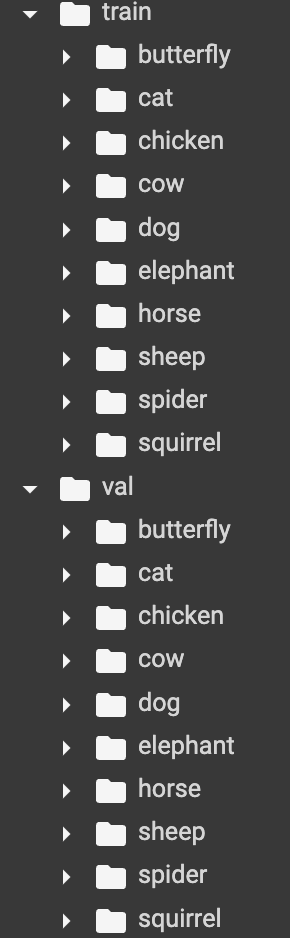

### 이미지 순서대로 넘버링
* 각 폴더 안에서 편의를 위해 0번부터 넘버링되도록 파일 이름을 바꾸자
* 추후에 나올 `ImageFolder`를 활용한다면 굳이 거쳐야 하는 과정은 아님

In [86]:
# random한 번호로 값이 들어가있다.

flat_val = sorted(glob.glob('/content/val/cow/*.jpeg'))
flat_val[:5]

['/content/val/cow/cow (1).jpeg',
 '/content/val/cow/cow (10).jpeg',
 '/content/val/cow/cow (101).jpeg',
 '/content/val/cow/cow (11).jpeg',
 '/content/val/cow/cow (116).jpeg']

In [87]:
i = 4
print(f'{i:0>5}') # 이 형식으로 바꿀예정

i = 200
print(f'{i:0>5}') # 이 형식으로 바꿀예정

00004
00200


In [90]:
def rename(img_dir):

    # img_dir : rename을 할 대상 폴더
    file_list = sorted(glob.glob(img_dir+'/*.jpg')) # 들어있는 파일이름 리스트
    file_list += sorted(glob.glob(img_dir+'/*.jpeg'))
    file_list += sorted(glob.glob(img_dir+'/*.png'))
    
    for i in range(len(file_list)):
        extension = file_list[i].split('.')[-1]
        os.rename(file_list[i], os.path.join(img_dir, f'{i:0>5}.{extension}')) # 순서대로 0000i.png 이름 변경

In [91]:
for key in path_dict:
    path = '/content/train/{}'.format(key)
    rename(path)
    path = '/content/val/{}'.format(key)
    rename(path)

In [92]:
# 잘 rename 되었는지 확인

flat_train = sorted(glob.glob('/content/train/cow/*'))
flat_val = sorted(glob.glob('/content/val/cow/*'))

print(flat_train[:5])
print(flat_val[-5:])

['/content/train/cow/00000.jpeg', '/content/train/cow/00001.jpeg', '/content/train/cow/00002.jpeg', '/content/train/cow/00003.jpeg', '/content/train/cow/00004.jpeg']
['/content/val/cow/00055.jpeg', '/content/val/cow/00056.jpeg', '/content/val/cow/00057.jpeg', '/content/val/cow/00058.jpeg', '/content/val/cow/00059.jpeg']


### Custom Dataset Class 만들기

In [94]:
from torch.utils.data import Dataset

파일 구조 재확인

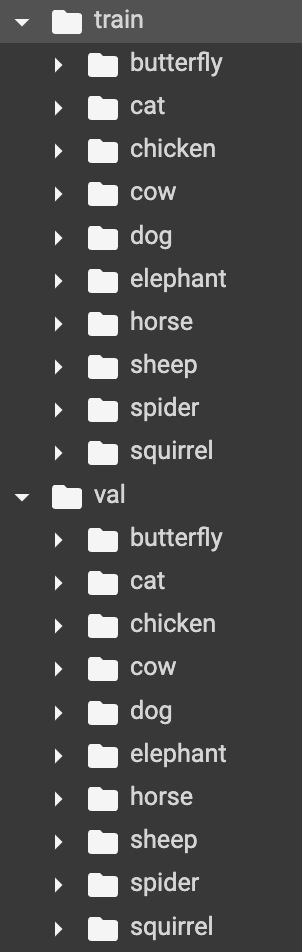

In [95]:
!ls

animals10      drive	Haaland.zip  Mbappe.zip   soccer.zip  val
animals10.zip  Haaland	Mbappe	     sample_data  train


In [96]:
%cd animals10
!ls

/content/animals10
butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [97]:
!pwd

/content/animals10


In [98]:
path = '/content/animals10'

데이터 파일 구조와 y_class에 따라 customizing하여 아래 클래스를 바탕으로 수정하여 사용하시면 됩니다.
* 그러니까 아래 있는 거는 한가지 예시라고만 보시면 될 것 같아요.
* 변수명이나 경로 그리고 jpg,jpeg,png 등 자신의 환경에 따라 고쳐야할게 많습니다 ㅎㅎ


In [99]:
path_dict

{'dog': ['/content/animals10/dog/dog (1).jpeg',
  '/content/animals10/dog/dog (10).jpeg',
  '/content/animals10/dog/dog (100).jpeg',
  '/content/animals10/dog/dog (101).jpeg',
  '/content/animals10/dog/dog (102).jpeg',
  '/content/animals10/dog/dog (103).jpeg',
  '/content/animals10/dog/dog (104).jpeg',
  '/content/animals10/dog/dog (105).jpeg',
  '/content/animals10/dog/dog (106).jpeg',
  '/content/animals10/dog/dog (107).jpeg',
  '/content/animals10/dog/dog (108).jpeg',
  '/content/animals10/dog/dog (109).jpeg',
  '/content/animals10/dog/dog (11).jpeg',
  '/content/animals10/dog/dog (110).jpeg',
  '/content/animals10/dog/dog (111).jpeg',
  '/content/animals10/dog/dog (112).jpeg',
  '/content/animals10/dog/dog (113).jpeg',
  '/content/animals10/dog/dog (114).jpeg',
  '/content/animals10/dog/dog (115).jpeg',
  '/content/animals10/dog/dog (116).jpeg',
  '/content/animals10/dog/dog (117).jpeg',
  '/content/animals10/dog/dog (118).jpeg',
  '/content/animals10/dog/dog (119).jpeg',
  '/cont

In [260]:
import glob
import random
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class mycustom_DataSet(Dataset):
    def __init__(self, path, train=True, transform=None, n=-1):
        
        self.path = path

        # class값들의 이름 저장한 리스트
        class_list = os.listdir(self.path+'/train/')

        # train
        if train:
            # '/content/train/경로 안에 있는 폴더이름(=class이름)'
            self.folder_list = [self.path + '/train/' + key for key in class_list]
        # val
        else:
            # '/content/val/경로 안에 있는 폴더이름(=class이름)'
            self.folder_list = [self.path + '/val/' + key for key in class_list]


        #self.list
        self.img_list = []
        self.class_list = []

        # 해당 경로의 이름을 갖는 파일들을 모두 리스트안에 저장
        for folders in self.folder_list:
          self.img_list = glob.glob(folders + '/*.jpg')
          self.img_list += glob.glob(folders + '/*.png')
          self.img_list += glob.glob(folders + '/*.jpeg')
        
        if n==-1: # 입력하지 않으면, 모든 데이터를 사용한다.
            self.n = len(self.img_list)
        else: # 입력하면, 입력된 n개만큼의 데이터를 사용한다.
            self.n = n

        for i in range(len(self.img_list)):
          self.class_list += [i] * len(self.img_list)

        idx = random.sample(range(0,len(self.img_list)),self.n)
        self.img_list += list(np.sort(np.array(self.img_list)[idx]))

    
        # transform을 transform이라는 변수에 저장
        self.transform = transform



    def __len__(self):
        return len(self.img_list)



    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        label = self.class_list[idx]
        temp = Image.open(img_path)
        temp = np.array(temp)
        temp = temp[:,:,:3] # 즉, 4개짜리 channels을 갖는 이미지가 몇 개 존재한다. 따라서 channels 중에 마지막 channel을 제거해준다.
        img = Image.fromarray(temp)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [220]:
my_transform = transforms.Compose([
    transforms.Resize(250),            
    transforms.RandomCrop(224),             # 랜덤으로 224만큼 crop; 반드시 crop을 해야 W==H가 된다.
    
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),
    
    # 정규화는 아직 진행하지 않는다.
    transforms.ToTensor()
])

In [261]:
path = '/content'

train_data = mycustom_DataSet(path=path, train=True, transform=my_transform, n = 240)

len(train_data)

480

In [262]:
val_data = mycustom_DataSet(path=path, train=False, transform=my_transform, n = 60)
len(val_data)

120

mycustom_DataSet( ) class 로 만든 Dataset 특성 확인

In [263]:
train_data[0] # 1번째 데이터

(tensor([[[-1.1315, -1.1315, -1.1315,  ..., -1.1315, -1.1315, -1.1315],
          [-1.1315, -1.1315, -1.1315,  ..., -1.1315, -1.1315, -1.1315],
          [-1.1315, -1.1315, -1.1315,  ..., -1.1315, -1.1315, -1.1315],
          ...,
          [-1.1315, -1.1315, -1.1315,  ..., -1.1315, -1.1315, -1.1315],
          [-1.1315, -1.1315, -1.1315,  ..., -1.1315, -1.1315, -1.1315],
          [-1.1315, -1.1315, -1.1315,  ..., -1.1315, -1.1315, -1.1315]],
 
         [[-1.2497, -1.2497, -1.2497,  ..., -1.2497, -1.2497, -1.2497],
          [-1.2497, -1.2497, -1.2497,  ..., -1.2497, -1.2497, -1.2497],
          [-1.2497, -1.2497, -1.2497,  ..., -1.2497, -1.2497, -1.2497],
          ...,
          [-1.2497, -1.2497, -1.2497,  ..., -1.2497, -1.2497, -1.2497],
          [-1.2497, -1.2497, -1.2497,  ..., -1.2497, -1.2497, -1.2497],
          [-1.2497, -1.2497, -1.2497,  ..., -1.2497, -1.2497, -1.2497]],
 
         [[-1.3690, -1.3690, -1.3690,  ..., -1.3690, -1.3690, -1.3690],
          [-1.3690, -1.3690,

In [264]:
# 1번째 데이터의 X값(이미지 정보)

train_data[0][0].shape # 모양만 확인

torch.Size([3, 224, 224])

In [265]:
# 1번쨰 데이터의 y값(label 클래쓰 정보)

train_data[0][1]

0

In [266]:
# 모든 데이터의 y값(label 클래쓰 정보)

y_list = []

for i in range(len(train_data)):
    y_list.append(train_data[i][1])

import pandas as pd
y_pd = pd.Series(np.array(y_list)).value_counts()
y_pd = y_pd.sort_index()
y_pd

0    240
1    240
dtype: int64

### 데이터에 맞는 transforms 찾기

#### 1. 사이즈 조절

기존의 my_transform을 적용한 결과에 대한 시각화
* 각 클래쓰 별로 일부 데이터를 가져와서 확인해보자.

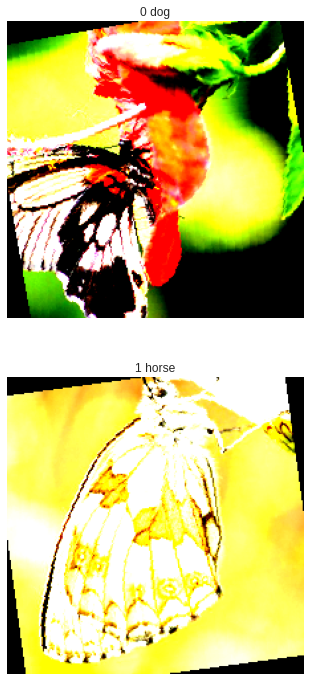

In [267]:
figure = plt.figure(figsize=(24,12))

for i in range(len(y_pd.index)):

    data_np = np.array(train_data[y_pd[:i].sum()][0])
    data_tr = data_np.transpose(1,2,0)

    plt.subplot(len(y_pd.index),1,i+1)
    plt.imshow(data_tr)
    plt.axis('off')
    plt.title('{} {}'.format(train_data[y_pd[:i].sum()][1], class_list[i]))

plt.show()

#### 2. 정규화를 위한 평균,표준편차 구하기
* 사진의 이미지 크기(HxW)를 동일하게 변경시켜준 뒤에, 평균과 표준편차를 구한다.

In [268]:
import pandas as pd

def calculate_norm(dataset):
    mean_ = np.array([np.mean(x.numpy(), axis = (1, 2)) for x in data])

    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    std_ = np.array([np.std(x.numpy(), axis = (1, 2)) for x in data])

    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [269]:
# train 데이터만을 기준으로 평균과 표준편차를 구해서 넣는다.

mean_, std_ = calculate_norm(train_data)

print(mean_, std_)

(0.2805512, 0.2949607, 0.33172703) (0.24794498, 0.23602118, 0.2423068)


In [270]:
my_transform = transforms.Compose([
    transforms.Resize(250),            
    transforms.RandomCrop(224),             # 랜덤으로 224만큼 crop
    
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),
    
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_) # 정규화 진행

])

In [271]:
!pwd

/content/animals10


In [272]:
# 정규화 적용 후

mean_, std_ = calculate_norm(train_data)
print('train :', mean_, std_)

mean_, std_ = calculate_norm(val_data)
print('val :', mean_, std_)

train : (0.2805512, 0.2949607, 0.33172703) (0.24794498, 0.23602118, 0.2423068)
val : (0.2805512, 0.2949607, 0.33172703) (0.24794498, 0.23602118, 0.2423068)


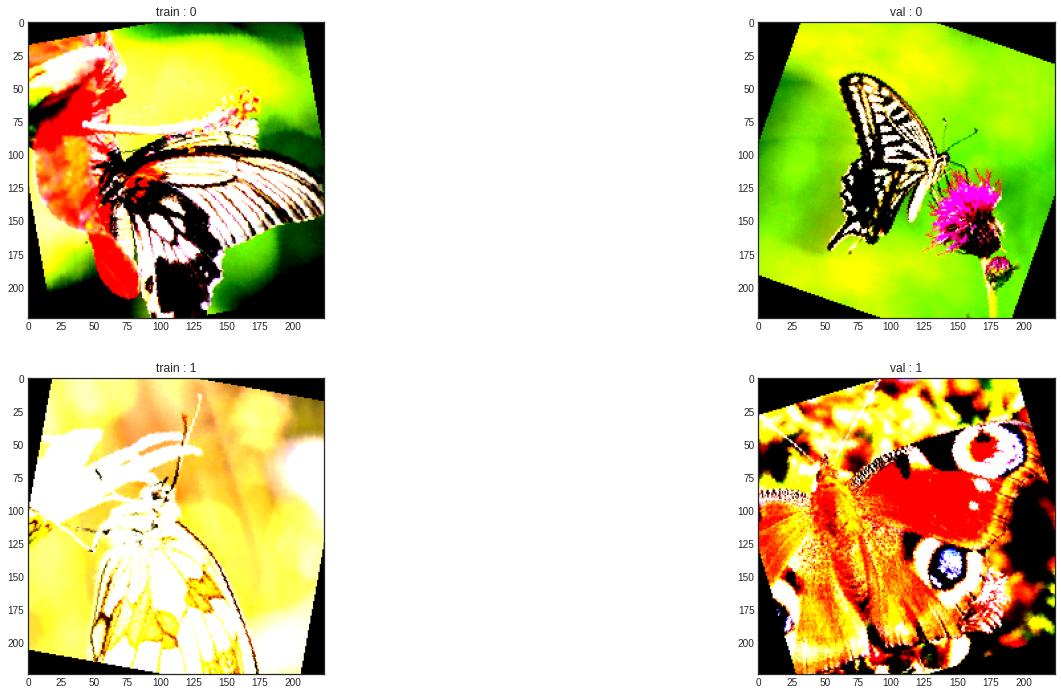

In [273]:
# train/val 데이터 시각화

figure = plt.figure(figsize=(24,12))

data_list = [train_data, val_data]
name_list = ['train', 'val']

for i in range(len(data_list)):

    # 각 train/val 별 y-value값으로 사이즈 확인
    y_list = []

    for k in range(len(data_list[i])):
        y_list.append(data_list[i][k][1])

    y_pd = pd.Series(np.array(y_list)).value_counts().sort_index()

    for j in range(len(y_pd.index)): # flat/full/no-animals10

        data_np = np.array(data_list[i][y_pd[:j].sum()][0])
        data_tr = data_np.transpose(1,2,0)

        plt.subplot(len(y_pd.index),2,i+2*j+1)
        plt.imshow(data_tr)
        plt.title('{} : {}'.format(name_list[i], data_list[i][y_pd[:j].sum()][1]))

plt.show()

# 시각적으로 구분이 가능해보인다.

## Step2. 전이학습 / 모델 학습(2)
> 고정된 특징 추출기로써의 합성곱 신경망
> 구조 변경은 하였지만, 변경한 구조를 제외한 나머지 weights들은 고정시킨다.
* 마지막 계층을 제외한 신경망의 모든 부분을 고정
*  `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.

### 전처리 설정

In [274]:
# 위에서 결정된 transform을 토대로, train/val에 대한 transform-dictionary 정의하기

data_transforms = transforms.Compose([
    transforms.Resize(250),            
    transforms.RandomCrop(224),
    
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(20),
    
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_)
])

In [276]:
data_dir = '/content'

# Custom-Dataset으로 만든 Datasets
image_datasets = {'train' : mycustom_DataSet(path=data_dir, train=True, transform=data_transforms, n=240),
                  'val' : mycustom_DataSet(path=data_dir, train=False, transform=data_transforms, n=60)}


# DataLoader( ) 로 batch-size 만큼 데이터를 쪼갠 그룹 만들기
dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [277]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f36dbe7f220>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f36dbe980d0>}

In [278]:
for inputs, labels in dataloaders['train']:
    print(inputs.shape, '\n')
    print(labels.shape)

    break;

torch.Size([4, 3, 224, 224]) 

torch.Size([4])


In [279]:
dataset_sizes

{'train': 480, 'val': 120}

In [282]:
class_list

['dog',
 'horse',
 'elephant',
 'cow',
 'sheep',
 'chicken',
 'cat',
 'spider',
 'squirrel',
 'butterfly']

In [284]:
len(class_list)

10

### 사전훈련된 모델 로드

In [285]:
model_ft = models.resnet18(pretrained=True) # torchvision 라이브러리로부터 이미 학습된 모델인 'resnet18'을 가져온다.
model_ft

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

(매우 중요) 변경된 layer와 관련된 가중치가 아닌 부분은 모두 가중치 업데이트가 되지 않도록 한다.

In [287]:
for param in model_ft.parameters():
    param.requires_grad = False # gradient 계산 추적을 하지 않도록 한다.

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000
  - 가장 마지막의 layer이자 유일한 fc-layer의 output node 값이 1,000개로 1,000개의 class로 분류가 되는 모델이다.
  - 따라서 우리의 분류문제는 10개의 class 임으로, 해당 변수를 nn.Linear(512, 10) 로 변경해주자.

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [289]:
# model class의 fc 변수 중 out_features를 변경

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

# gpu위에 올린다.
model_ft = model_ft.to(device)

### 손실함수와 옵티마이저

In [293]:
criterion = nn.CrossEntropyLoss() # 분류 -> 다중 cross-entropy

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [294]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler

- 학습 함수 정의

### model의 train & validation 동시 구현

이전 것 그대로 사용

In [295]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # 시작시점 기록

    # 모델의 weight(가중치)를 깊은 복사하여, 이 변수가 변해도 해당 모델의 weight가 변하지 않도록 한다.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs): # epochs만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train','val']: # train -> validation 순차 진행
            if phase == 'train':
                model.train() # train일 때는, layer의 batch-normal과 drop-out 등 을 활성화시킨다.
            else:
                model.eval() # validation(=evaluation) 때는, layer의 batch-normal과 drop-out 등 을 비활성화시킨다.
                # 즉, 이전에 train에서 정해진 값들로 정해지고, update는 없다.

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # batch마다
                inputs = inputs.to(device) # gpu위에 올린다; [4, 3, 224, 224]
                labels = labels.to(device) # gpu위에 올린다; [4]

                optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

                with torch.set_grad_enabled(phase == 'train'): # train일 때, True로 새로 정의된 변수들의 연산들이 추적되어 gradient가 계산된다.
                    outputs = model(inputs) # 실수값
                    _, preds = torch.max(outputs, 1) # 가장 큰 값을 선택; 분류
                    loss = criterion(outputs, labels) # loss-function

                    if phase == 'train':
                        loss.backward() # back-propagation; gradient 계산
                        optimizer.step() # parameters(weights) update
                
                running_loss += loss.item() * inputs.size(0) # inputs.size(0) = batch-size; 4
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # validation의 목적; train 시킨 후에, 정해진 각 epochs마다 모델 성능을 비교하여, 가능 좋은 값을 찾아낸다.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts) # 가장 좋은 성능을 보인 가중치로 바꿔주기
    return model


In [297]:
# 모델 train & validation

model_ft = train_model(dataloaders, model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.9368	Accuracy: 0.4458
val Loss: 0.7775	Accuracy: 0.5333

Epoch 1/9
----------
train Loss: 1.0956	Accuracy: 0.5062
val Loss: 1.2647	Accuracy: 0.5000

Epoch 2/9
----------
train Loss: 0.9186	Accuracy: 0.4688
val Loss: 0.7652	Accuracy: 0.5167

Epoch 3/9
----------
train Loss: 0.8832	Accuracy: 0.5042
val Loss: 1.0019	Accuracy: 0.4917

Epoch 4/9
----------
train Loss: 0.8846	Accuracy: 0.4646
val Loss: 0.8712	Accuracy: 0.5167

Epoch 5/9
----------
train Loss: 0.9065	Accuracy: 0.4875
val Loss: 0.9552	Accuracy: 0.5083

Epoch 6/9
----------
train Loss: 0.9073	Accuracy: 0.4646
val Loss: 0.7566	Accuracy: 0.5417

Epoch 7/9
----------
train Loss: 0.7354	Accuracy: 0.5167
val Loss: 0.7862	Accuracy: 0.4750

Epoch 8/9
----------
train Loss: 0.7433	Accuracy: 0.4813
val Loss: 0.8118	Accuracy: 0.4833

Epoch 9/9
----------
train Loss: 0.7437	Accuracy: 0.5000
val Loss: 0.7805	Accuracy: 0.4750

Training time: 1m 9s
Best Validation Accuracy: 0.5417


### 결과 시각화

- 시각화 함수 정의

이전 것 그대로 사용

In [298]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [302]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_list[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


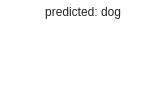

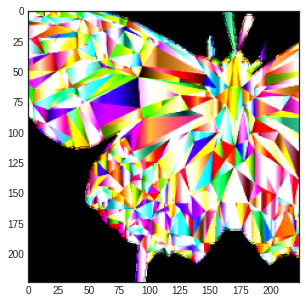

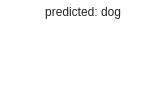

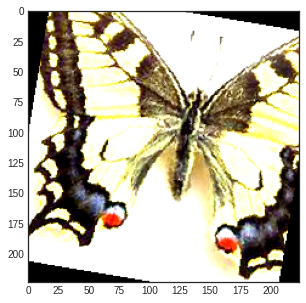

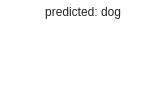

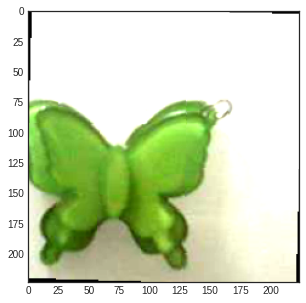

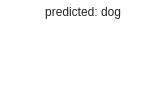

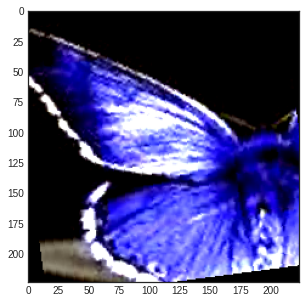

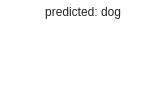

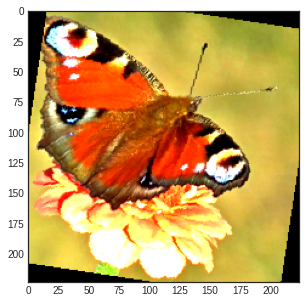

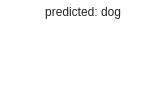

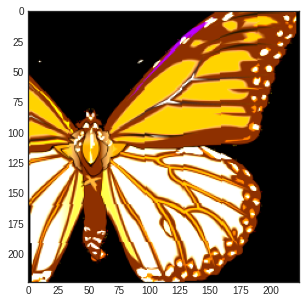

In [303]:
visualize_model(model_ft)

# 수고하셨습니다.